In [2]:
!unzip /content/drive/MyDrive/KRX/open.zip -d /content/drive/MyDrive/KRX

Archive:  /content/drive/MyDrive/KRX/open.zip
  inflating: /content/drive/MyDrive/KRX/sample_submission.csv  
  inflating: /content/drive/MyDrive/KRX/train.csv  


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/KRX/train.csv')
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [4]:
df.describe(include='object')

,종목코드,종목명
count,988000,988000
unique,2000,2000
top,A060310,3S
freq,494,494


In [5]:
df = df.drop(columns='종목명')
df.head()

,일자,종목코드,거래량,시가,고가,저가,종가
0,20210601,A060310,166690,2890,2970,2885,2920
1,20210601,A095570,63836,5860,5940,5750,5780
2,20210601,A006840,103691,35500,35600,34150,34400
3,20210601,A054620,462544,14600,14950,13800,14950
4,20210601,A265520,131987,29150,29150,28800,29050


종목코드별로 일자순으로 데이터를 분할

종목수

In [6]:
df.describe(include='object').loc['unique']

종목코드    2000
Name: unique, dtype: object

In [7]:
gdata = df.groupby(['종목코드'])
gdata.get_group('A060310')


,일자,종목코드,거래량,시가,고가,저가,종가
0,20210601,A060310,166690,2890,2970,2885,2920
2000,20210602,A060310,134833,2915,2975,2830,2900
4000,20210603,A060310,144470,2900,2925,2875,2900
6000,20210604,A060310,934224,2930,3120,2920,2950
8000,20210607,A060310,946560,3000,3150,2955,3150
...,...,...,...,...,...,...,...
978000,20230523,A060310,117084,2300,2315,2260,2285
980000,20230524,A060310,67101,2280,2300,2255,2280
982000,20230525,A060310,91789,2260,2285,2235,2245
984000,20230526,A060310,13590249,2245,2915,2230,2910


In [8]:
df_datas = []
for i in gdata:
  df_datas.append(i[1])

<ipython-input-8-9c26707d9286>:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i in gdata:


In [9]:
len(df_datas)

2000

In [10]:
df_datas[0]['일자'].to_numpy()[-1]

20230530

In [11]:
import numpy as np
np.unique( [len(data) for data in df_datas] )

array([494])

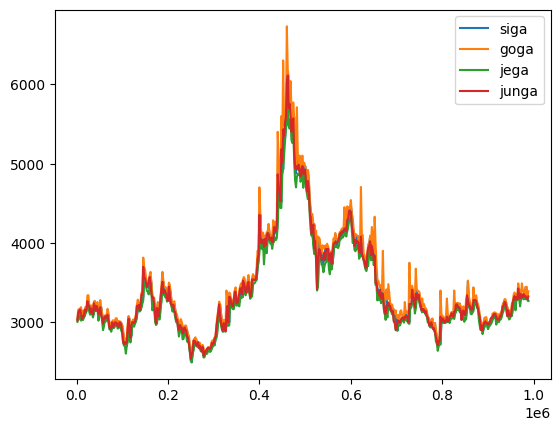

In [14]:
import matplotlib.pyplot as plt
plt.plot(df_datas[100]['시가'],label='siga')
plt.plot(df_datas[100]['고가'],label='goga')
plt.plot(df_datas[100]['저가'],label='jega')
plt.plot(df_datas[100]['종가'],label='junga')
plt.legend()
plt.show()

In [35]:
import tensorflow as tf

데이터 분할  (학습,검증,테스트)

In [72]:
train_len = int(len(df_datas[0])*0.5)
val_len = int(len(df_datas[0])*0.25)
test_len = len(df_datas[0]) - train_len-val_len

In [73]:
sequence_length = 10
# batch_size = 30
def get_dataset(raw_data, target_data):
  train_dataset =  tf.keras.utils.timeseries_dataset_from_array(
      data = raw_data[:-sequence_length],
      targets= target_data[sequence_length:],
      sequence_length = sequence_length,
      # batch_size=batch_size ,
      # shuffle=True,
      # start_index = 0,
      # end_index=train_len
  )

  # val_dataset =  tf.keras.utils.timeseries_dataset_from_array(
  #     data = raw_data[:-sequence_length],
  #     targets = target_data[sequence_length:],
  #     sequence_length = sequence_length,
  #     # batch_size=batch_size ,
  #     # shuffle=True,
  #     start_index = train_len,
  #     end_index=train_len+val_len
  # )
  # test_dataset =  tf.keras.utils.timeseries_dataset_from_array(
  #     data = raw_data[:-sequence_length],
  #     targets = target_data[sequence_length:],
  #     sequence_length = sequence_length,
  #     # shuffle=True,
  #     # batch_size=batch_size ,
  #     start_index = train_len+val_len,
  # )
  return train_dataset#,val_dataset,test_dataset

In [74]:
raw_data = df_datas[0].iloc[:,2:].to_numpy()
target_data = df_datas[0]['종가'].to_numpy()
raw_data.shape, target_data.shape

((494, 5), (494,))

In [75]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
raw_data = scaler.fit_transform(raw_data)

In [76]:
train_data_set =  get_dataset(raw_data,target_data)

In [80]:
type(train_data_set)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
for data,target in train_data_set:
  print(f"data:{data.shape}")
  print(f'target:{target}')
  break

LMST

In [ ]:
inputs = tf.keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = tf.keras.layers.LSTM(64,activation='tanh',return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(32,activation='tanh', recurrent_dropout=0.25)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10,activation='relu')(x)
outputs = tf.keras.layers.Dense(15)(x)
model = tf.keras.Model(inputs,outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
hist = model.fit(train_data_set,epochs=10)

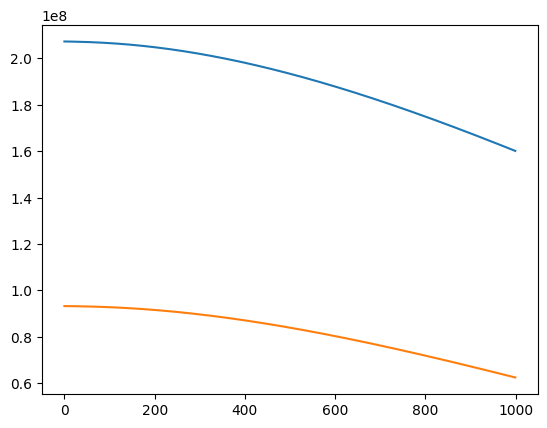

In [82]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'],label='val loss')
plt.show()


In [89]:
raw_data[-sequence_length:].reshape(1,sequence_length,5)
predicted_data = model.predict( raw_data[-sequence_length:].reshape(1,sequence_length,5) )

1/1 [==============================] - 0s 31ms/step


In [92]:
predicted_data.shape

(1, 15)

In [95]:
final_return  = (predicted_data[0][-1] - predicted_data[0][0]) / predicted_data[0][0]

-0.0036357332

In [96]:
# 데이터 - 종목별 - 스케일링
# 모델 - 학습
# 예측
# 수익률

In [ ]:
!unzip /content/drive/MyDrive/KRX/open.zip -d /content/drive/MyDrive/KRX

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/KRX/train.csv')
gdata = df.groupby(['종목코드'])

In [137]:
results_df = pd.DataFrame(columns=['종목코드', 'final_return'])
# 모델
inputs = tf.keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = tf.keras.layers.LSTM(64,activation='tanh',return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(32,activation='tanh', recurrent_dropout=0.25)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10,activation='relu')(x)
outputs = tf.keras.layers.Dense(15)(x)
model = tf.keras.Model(inputs,outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.fit(train_data_set,epochs=10)

GRUD : 드랍아웃 스태킹

In [146]:
inputs = tf.keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = tf.keras.layers.GRU(32,return_sequences=True,recurrent_dropout=0.5)(inputs)
x = tf.keras.layers.GRU(32,recurrent_dropout=0.5)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(15)(x)
model = tf.keras.Model(inputs,outputs)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [138]:
dic_data = dict((i[0],i[1])  for i in gdata  )

<ipython-input-138-eddea79e6e39>:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  dic_data = dict((i[0],i[1])  for i in gdata  )


In [139]:
from sklearn.preprocessing import MinMaxScaler
raw_data = scaler.fit_transform(raw_data)
sequence_length = 10
def load_dataset(raw_data, target_data):
  scaler = MinMaxScaler()
  raw_data = scaler.fit_transform(raw_data)
  # sequence_length = 10
  dataset =  tf.keras.utils.timeseries_dataset_from_array(
      data = raw_data[:-sequence_length],
      targets= target_data[sequence_length:],
      sequence_length = sequence_length
  )
  return dataset

In [148]:
from tqdm import tqdm
for key in tqdm(dic_data):
  print(f"종목 : {key}")
  data = dic_data[key]
  raw_data = data.iloc[:,-5:]
  target_data = raw_data.iloc[:,-1]
  raw_data = raw_data.to_numpy()
  target_data = target_data.to_numpy()
  train_dataset = load_dataset(raw_data,target_data)

  model.fit(train_dataset,epochs=1000,verbose=0)
  raw_data[-sequence_length:].reshape(1,sequence_length,5)
  predicted_data = model.predict( raw_data[-sequence_length:].reshape(1,sequence_length,5) )
  final_return  = (predicted_data[0][-1] - predicted_data[0][0]) / predicted_data[0][0]
  results_df = results_df.append({'종목코드': key, 'final_return': final_return}, ignore_index=True)


  0%|          | 0/2000 [00:00<?, ?it/s]

종목 : A000020


  0%|          | 0/2000 [00:08<?, ?it/s]


KeyboardInterrupt: ignored

In [141]:
results_df['순위'] = results_df['final_return'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df

,종목코드,final_return,순위
0,A000020,-2.022685,1998
1,A000040,-2.779549,1999
2,A000050,-11.437632,2000
3,A000070,3.391590,1
4,A000080,1.727201,2
...,...,...,...
1995,A375500,0.000597,1993
1996,A378850,0.000596,1994
1997,A383220,0.000587,1995
1998,A383310,0.000583,1996


In [142]:
sample_submission = pd.read_csv('/content/drive/MyDrive/KRX/sample_submission.csv')
sample_submission

,종목코드,순위
0,A000020,1
1,A000040,2
2,A000050,3
3,A000070,4
4,A000080,5
...,...,...
1995,A375500,1996
1996,A378850,1997
1997,A383220,1998
1998,A383310,1999


In [143]:
baseline_submission = sample_submission[['종목코드']].merge(results_df[['종목코드', '순위']], on='종목코드', how='left')
baseline_submission

,종목코드,순위
0,A000020,1998
1,A000040,1999
2,A000050,2000
3,A000070,1
4,A000080,2
...,...,...
1995,A375500,1993
1996,A378850,1994
1997,A383220,1995
1998,A383310,1996


In [144]:
baseline_submission.to_csv('baseline_submission.csv', index=False)